<a href="https://colab.research.google.com/github/ping-Mel/ERV-V2-Assignments/blob/main/session11/s11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install ERA-V2-Architecture==0.1.8

  Preparing metadata (setup.py) ... done
  Created wheel for ERA-V2-Architecture: filename=ERA_V2_Architecture-0.1.8-py3-none-any.whl size=8759 sha256=93d7c5fbebbcc8b952884332da934feb45265a8fd45aa7a94f0eea1b65eb7a80
  Stored in directory: /root/.cache/pip/wheels/14/76/70/d0f9fe2c0e0f093f7fc7ffeb86abc78c1f1a9b9e1a564b1428
Successfully built ERA-V2-Architecture


In [2]:
from ERA_V2_Architecture.model import ResNet18
from ERA_V2_Architecture.model import BasicBlock
from ERA_V2_Architecture.model import Models
from ERA_V2_Architecture.model import initialize_device, get_dataloader_args, train, test, show_images,setup_dataloaders,get_training_stats
#from ERA_V2_Architecture.model import CIFAR10Albumentations
from ERA_V2_Architecture.model import GradCAM

#import torch
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim


# Now you can use the classes and functions defined in models.py


In [3]:
device, use_cuda = initialize_device()
dataloader_args = get_dataloader_args(use_cuda)

CUDA Available? True


In [4]:
train_loader, test_loader = setup_dataloaders(batch_size=256, num_workers=2, pin_memory=use_cuda)

100%|██████████| 170498071/170498071 [00:03<00:00, 43346023.26it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
model = ResNet18().to(device)


In [6]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=25, gamma=0.5)

In [7]:
EPOCHS = 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/196 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Loss=nan Batch_id=195 Accuracy=11.34%: 100%|██████████| 196/196 [00:41<00:00,  4.74it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 1


Loss=nan Batch_id=195 Accuracy=10.00%: 100%|██████████| 196/196 [00:38<00:00,  5.05it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 2


Loss=nan Batch_id=195 Accuracy=10.00%: 100%|██████████| 196/196 [00:39<00:00,  4.98it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 3


Loss=nan Batch_id=195 Accuracy=10.00%: 100%|██████████| 196/196 [00:39<00:00,  4.91it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 4


Loss=nan Batch_id=195 Accuracy=10.00%: 100%|██████████| 196/196 [00:40<00:00,  4.89it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 5


Loss=nan Batch_id=195 Accuracy=10.00%: 100%|██████████| 196/196 [00:40<00:00,  4.87it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 6


Loss=nan Batch_id=195 Accuracy=10.00%: 100%|██████████| 196/196 [00:40<00:00,  4.81it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 7


Loss=nan Batch_id=195 Accuracy=10.00%: 100%|██████████| 196/196 [00:40<00:00,  4.86it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 8


Loss=nan Batch_id=195 Accuracy=10.00%: 100%|██████████| 196/196 [00:40<00:00,  4.83it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 9


Loss=nan Batch_id=195 Accuracy=10.00%: 100%|██████████| 196/196 [00:40<00:00,  4.86it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)



In [8]:
train_losses, test_losses, train_acc, test_acc, failed_samples = get_training_stats()


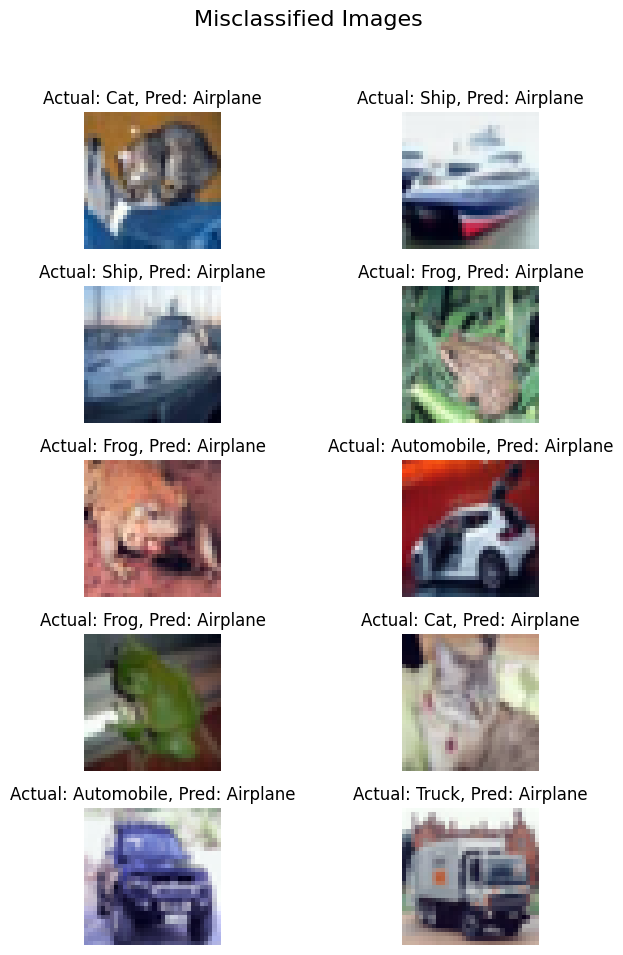

In [9]:
show_images(failed_samples,"Misclassified Images ")

In [ ]:
show_misclasses(grad_cam_samples,"Misclassified GradCAM Images ")